Classic4 Clustering

Downloading, unzipping and loading the classic4 database:

In [4]:
import os
import classicdb.fetch as fetch
from nltk.corpus import CategorizedPlaintextCorpusReader

url = fetch.URL
data_home = fetch.get_data_home()
classic_home = os.path.join(data_home, fetch.CLASSIC_HOME)
print("download and extracting file from " + url)
fetch.download_and_unzip(url, classic_home, fetch.ARCHIVE_NAME)
print("downloaded and extracted to " + classic_home)

corpus_root = os.path.join(classic_home, fetch.TRAIN_FOLDER)
corpus_reader = CategorizedPlaintextCorpusReader(corpus_root, r'.*', cat_pattern=r'(\w+)/*')
print("database was loaded into memory")

cats = corpus_reader.categories()
print("database categories: " + str(cats))

https://sites.google.com/site/xchgdir/public/classic.tar.gz?attredirects=0&d=1 was downloaded and extracted to C:\Users\khas.aiur\scikit_learn_data\classic_home
database was loaded into memory
database categories: ['cacm', 'cisi', 'cran', 'med']


Using sklearn's TfidfVectorizer with default configuration:

In [28]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer

labels = [cat for cat in corpus_reader.categories() for fileid in corpus_reader.fileids(cat)]
files = [corpus_reader.raw(fileid) for fileid in corpus_reader.fileids()]

start = time()
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(files)
print("done in %fs" % (time() - start))
print("m samples: %d, n features: %d" % X.shape)
print()

# terms = vectorizer.get_feature_names()
# print("some feature terms:")
# print(terms[0:100])
# print()

done in 0.986859s
m samples: 7095, n features: 24542



Using K-means for document clustering.

The k-means problem is solved using Lloyd's algorithm. The average complexity is given by O(k n T), were n is the number of samples and T is the number of iteration.
The worst case complexity is given by O(n^(k+2/p)) with n = n_samples, p = n_features. (D. Arthur and S. Vassilvitskii, 'How slow is the k-means method?' SoCG2006)
In practice, the k-means algorithm is very fast (one of the fastest clustering algorithms available), but it falls in local minima. That's why it can be useful to restart it several times.

Alternative online implementation that does incremental updates of the centers positions using mini-batches. For large scale learning (say n_samples > 10k) MiniBatchKMeans is probably much faster to than the default batch implementation.

Performance Evaluation

* __Homogeneity metric__ A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class. (Andrew Rosenberg and Julia Hirschberg, 2007. V-Measure: A conditional entropy-based external cluster evaluation measure)
  - homogeneity_score([0, 0, 1, 1], [1, 1, 0, 0]) => 1.0 

* 

In [46]:
from sklearn.cluster import KMeans
from sklearn import metrics

km = KMeans(n_clusters=len(corpus_reader.categories()),
            init='k-means++',  # or 'random' (random centroids) 
            n_init=10,  # number of time the k-means algorithm will be run with different centroid seeds.    
            max_iter=300
            )

print("Document clustering with %s" % km)
start = time()
km.fit(X)
print("done in %0.3fs" % (time() - start))
print()

print("true labels vs cluster labels")
print(labels[0:50])
print(km.labels_[0:50])
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km.labels_, sample_size=1000))
print()

Document clustering with KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


done in 7.629s

true labels vs cluster labels
['cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm', 'cacm']
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 2 2 2 2 2]

Homogeneity: 0.454
Completeness: 0.492
V-measure: 0.472
Adjusted Rand-Index: 0.276


Silhouette Coefficient: 0.009



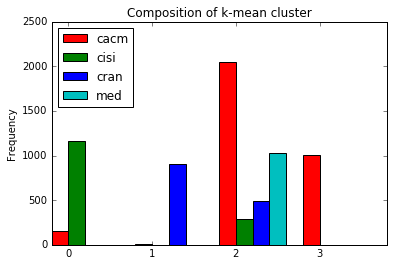

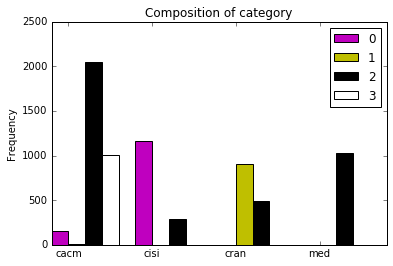

In [80]:
% matplotlib inline

from numpy import arange
from matplotlib import pyplot
from random import randint

def bar_chart(categories, words, counts, ylabel, title, colors='rgbcmyk', legendloc='upper left'):
    ind = arange(len(words))
    width = 1 / (len(categories) + 1)
    bar_groups = []
    for c in range(len(categories)):
        bars = pyplot.bar(ind + c * width, counts[categories[c]], width, color=colors[c % len(colors)])
        bar_groups.append(bars)
    pyplot.xticks(ind + width, words)
    pyplot.legend([b[0] for b in bar_groups], categories, loc=legendloc)
    pyplot.ylabel(ylabel)
    pyplot.title(title)
    pyplot.show()

clusters = np.unique(km.labels_)
labels = [cat for cat in corpus_reader.categories() for fileid in corpus_reader.fileids(cat)]

counts = {}
for c in corpus_reader.categories():
    counts[c] = len(clusters) * [0]
for l, label in enumerate(km.labels_):
    counts[labels[l]][label] += 1
# print(counts)
bar_chart(corpus_reader.categories(), clusters, counts, "Frequency", "Composition of k-mean cluster")

counts = {}
for i, c in enumerate(clusters[0:50]):
    counts[c] = len(corpus_reader.categories()) * [0]
label_ind = {}
cnt = 0
for cat in corpus_reader.categories():
    label_ind[cat] = cnt
    cnt +=1
for l, label in enumerate(labels): 
    counts[km.labels_[l]][label_ind[label]] += 1
# print(counts)
bar_chart(clusters, corpus_reader.categories(), counts, "Frequency", "Composition of category", colors='mykw',legendloc='upper right')